In [32]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv 
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, brier_score_loss, balanced_accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import warnings 
import math

warnings.filterwarnings('ignore')

In [33]:
%store -r xgb_model
%store -r filtered_trainDF
%store -r testDF

In [53]:
X = filtered_trainDF.drop(columns=['isFraud'])  # Features
y = filtered_trainDF['isFraud']  # Target

for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in col:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64')  # Convert to timestamp (int)

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object' or isinstance(X[col].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting problematic entries to NaN

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].mean())  # Numeric columns: fill with mean
    else:
        X[col] = X[col].fillna(X[col].mode()[0])  # Non-numeric columns: fill with mode

print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

TransactionID               int64
TransactionDT               int64
TransactionAmt            float64
ProductCD                   int64
card1                       int64
                           ...   
Card_Transaction_Mean     float64
Card_Transaction_Std      float64
Card_Transaction_Count      int64
Fraud_Prob                float64
card4_freq                float64
Length: 450, dtype: object
X_train shape: (425188, 450)
y_train shape: (425188,)


# --------------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis

In [35]:
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

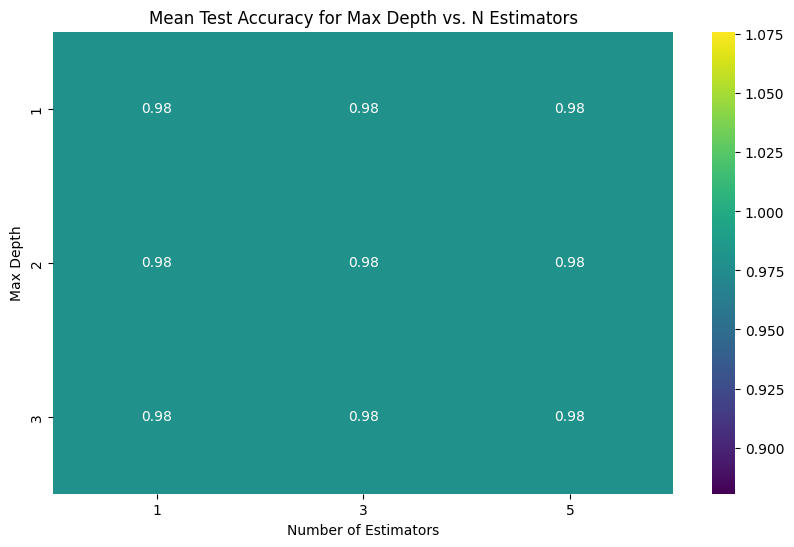

In [36]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score', 
                                     index='param_max_depth', 
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

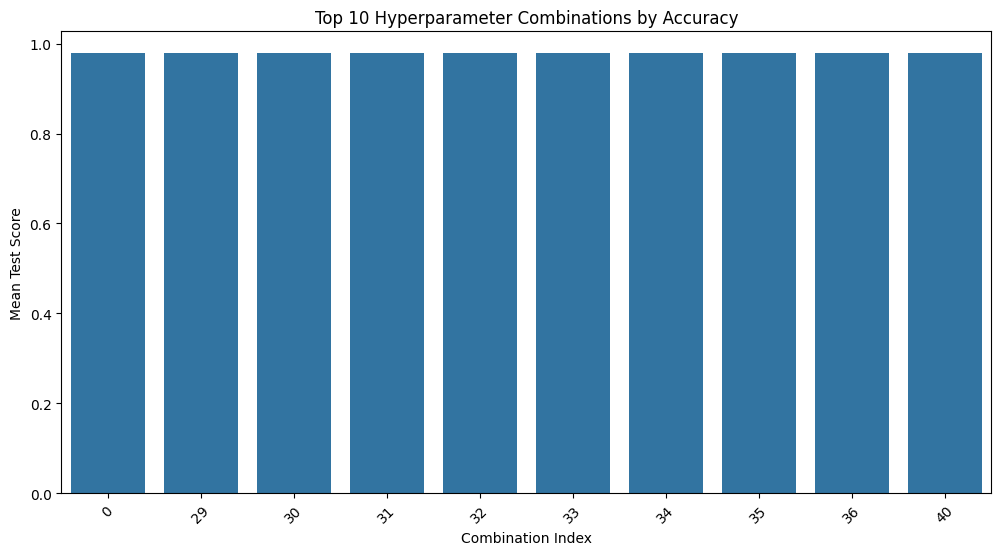

In [37]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

# --------------------------------------------------------------------------------------

# Top 10 Features Analysis

In [38]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

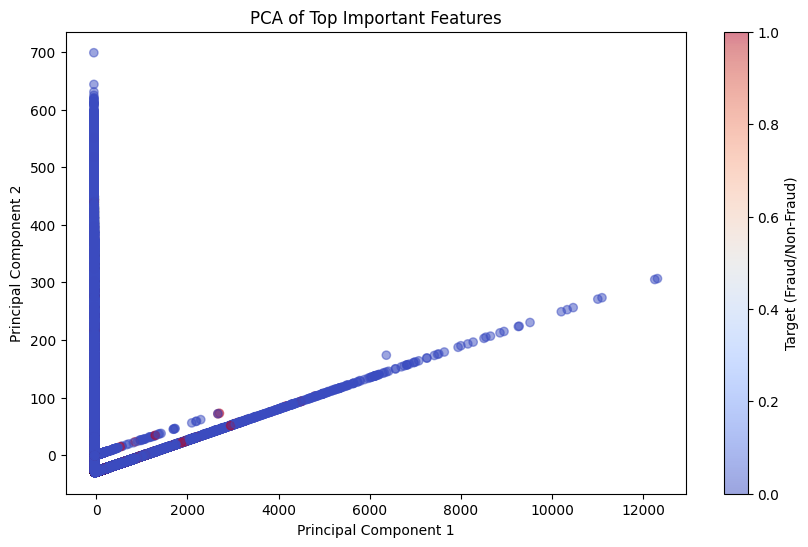

In [39]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [40]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9780


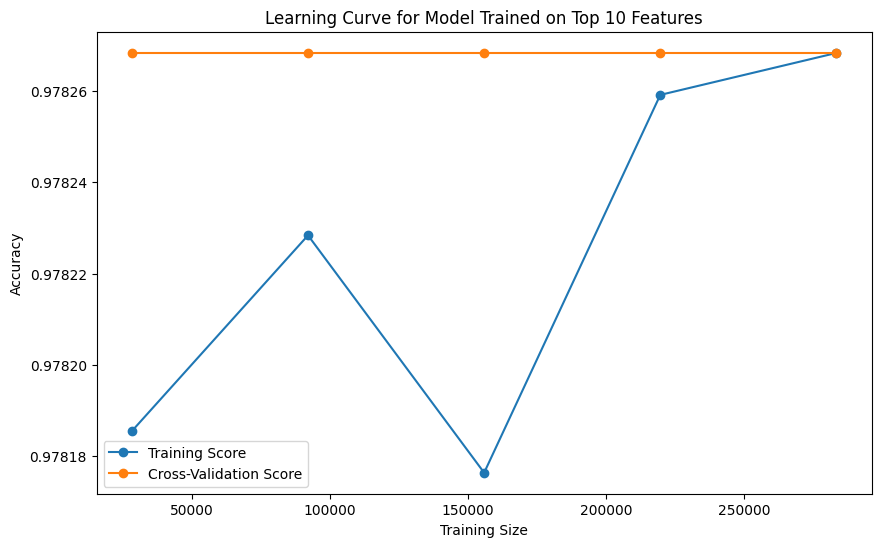

In [41]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features, 
                                                        X_train_top_features, 
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Accuracy of XGBoost on combined data: 0.9803


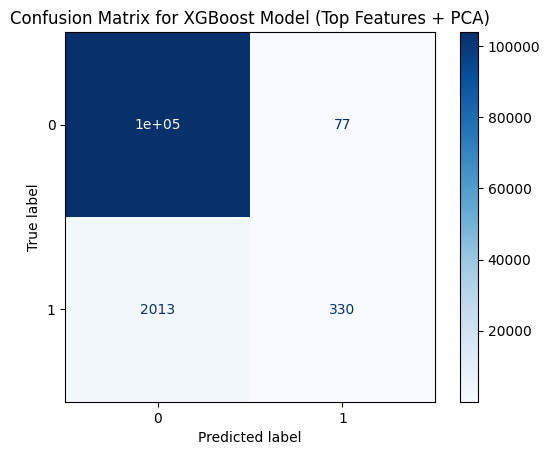

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine original top features and PCA components
X_combined = np.hstack([X_reduced, X_pca])

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(X_train_combined, y_train)

# Generate predictions
y_pred_combined = xgb_model_combined.predict(X_test_combined)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Accuracy of XGBoost on combined data: {accuracy_combined:.4f}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_combined.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model (Top Features + PCA)')
plt.show()

In [43]:
print(X_train_combined[0].size)

12


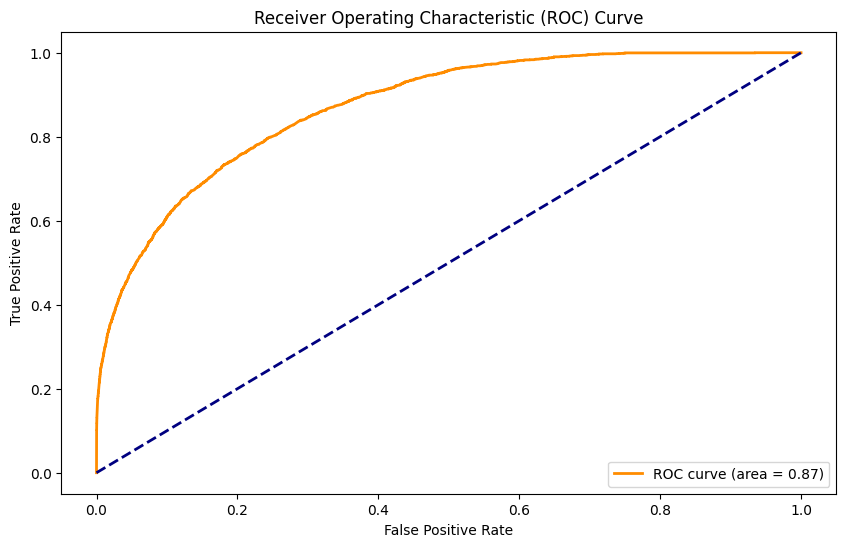

In [44]:
y_prob = xgb_model_combined.predict_proba(X_test_combined)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

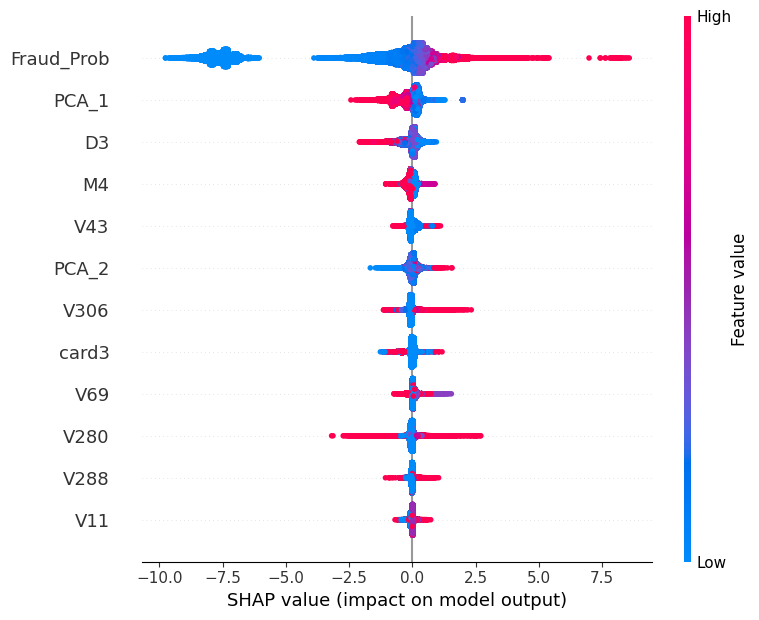

In [45]:
X_test_combined_df = pd.DataFrame(X_test_combined, columns=list(top_features) + ["PCA_1", "PCA_2"])

# Re-run the SHAP explainer with the DataFrame that includes column names
explainer = shap.TreeExplainer(xgb_model_combined)
shap_values = explainer.shap_values(X_test_combined_df)

# Summary plot with labeled features
shap.summary_plot(shap_values, X_test_combined_df)

# --------------------------------------------------------------------------------------

# Ensemble Method: Stacking + Blending

In [46]:
estimators = [
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_combined, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

Accuracy: 0.9802
Precision: 0.7120
Recall: 0.1741
F1 Score: 0.2798
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    103955
           1       0.71      0.17      0.28      2343

    accuracy                           0.98    106298
   macro avg       0.85      0.59      0.63    106298
weighted avg       0.98      0.98      0.97    106298



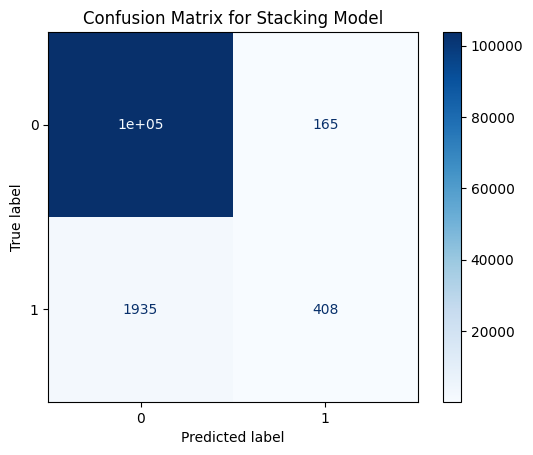

In [47]:
y_pred = stacking_model.predict(X_test_combined)
y_prob = stacking_model.predict_proba(X_test_combined)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

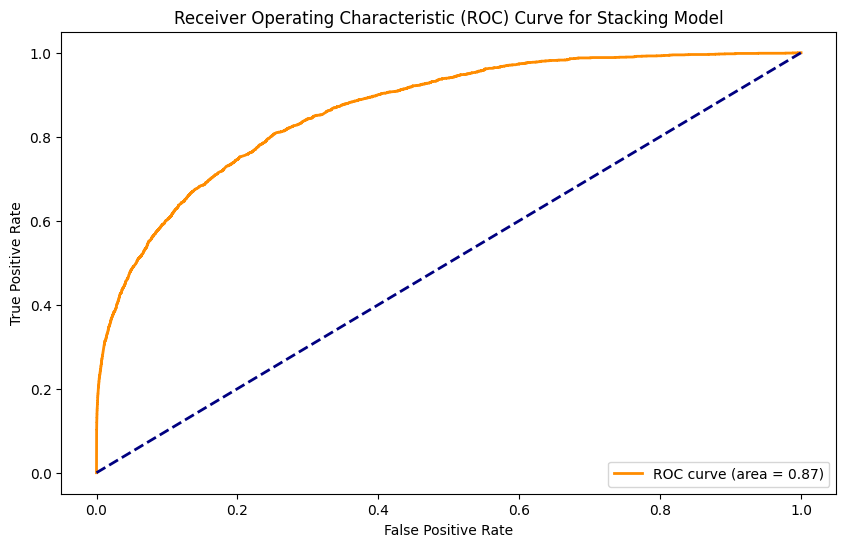

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Model')
plt.legend(loc='lower right')
plt.show()

# --------------------------------------------------------------------------------------

# Voting Model

In [49]:
weight_options = [
    [0.5, 0.3, 0.2],
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.2],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.7, 0.2, 0.1],
    [0.7, 0.1, 0.2]
]

best_score = 0
best_weights = None

# Iterate through different weight options
for weights in weight_options:
    voting_model.set_params(weights=weights)
    scores = cross_val_score(voting_model, X_train_combined, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_weights = weights

print(f"Best Weights: {best_weights} with Accuracy: {best_score:.4f}")

Best Weights: [0.4, 0.4, 0.2] with Accuracy: 0.9804


# --------------------------------------------------------------------------------------

# Repeated Nested Cross Validation

## Lasso for Feature Selection

In [55]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Convert to Numpy arrays for compatibility with Scikit-Learn
X_train = np.array(X_train)
y_train = np.array(y_train)

# Step 2: Define Outer and Inner Cross-Validation
# The outer CV is used to evaluate the model, and the inner CV is used for hyperparameter tuning
# Ensure that outer and inner loops have different random states to avoid overlapping splits
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)  # CHANGE RANDOM STATE to ensure non-overlapping indices
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=84)  # Different random state from outer_cv

# Step 3: Define Base Models
# These models will be used in the Voting Classifier ensemble
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(random_state=42)

num_features = 450
lower_bound_depth = int(np.floor(np.log2(num_features)))  # Approximate lower bound
upper_bound_depth = num_features  # Upper bound is the total number of features

# Define new depth range based on the heuristic
depth_range = [lower_bound_depth, lower_bound_depth + 2, int(upper_bound_depth / 2)]

# Updated parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': depth_range,  # Adjusted based on number of features
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize lists to store metrics for each outer fold
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

# Step 4: Nested Repeated Cross-Validation Loop
# Creating consensus feature so that in different loops different selections of features are taken into account
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Feature Selection using LASSO Regression in the Inner Loop
    # Using LASSO (LassoCV) for feature selection based on the value of coefficients
    # Look for n_alphas parameter in LassoCV and ensure cross-validation is consistent
    lasso = LassoCV(cv=inner_cv, random_state=42).fit(X_outer_train, y_outer_train)  # Use inner_cv for consistency
    selected_features = np.where(lasso.coef_ != 0)[0]  # Select features with non-zero coefficients

    # Reduce the training and test set to only the selected features
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    # This is meaningful only after feature selection to optimize hyperparameters on a refined feature set
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=10,  # Number of iterations for Randomized Search
        scoring='accuracy',
        cv=inner_cv,  # Use inner_cv for hyperparameter tuning
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_  # Get the best model from the inner loop

    # Define the Voting Classifier with the tuned model
    # The voting classifier combines multiple models to improve performance
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',  # Soft voting averages predicted probabilities
        weights=[0.4, 0.4, 0.2]  # Assign different weights to different models
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]  # Predicted probabilities for ROC-AUC

    # Store metrics for each outer fold
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred))
    outer_recall.append(recall_score(y_outer_test, y_pred))
    outer_f1.append(f1_score(y_outer_test, y_pred))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))

# Print average metrics across all outer folds
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")



X_train shape: (425188, 450)
y_train shape: (425188,)
Accuracy: 0.9783 ± 0.0000
Precision: 0.0000 ± 0.0000
Recall: 0.0000 ± 0.0000
F1 Score: 0.0000 ± 0.0000
ROC-AUC Score: 0.5679 ± 0.0042


InvalidIndexError: (slice(None, None, None), array([437]))

In [56]:
# Step 5: Final Model Training on the Entire Dataset
# The final voting model is trained on the entire dataset using the selected features
voting_model.fit(X_train[:, selected_features], y_train)

# Step 6: Evaluate the Final Model on the Independent Test Set
# Apply the same feature selection to the independent test set
X_test = np.array(X_test) 
X_test_selected = X_test[:, selected_features]
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1]

# Calculate and print final metrics for the independent test set
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

Final Model Accuracy: 0.9780
Final Model Precision: 0.0000
Final Model Recall: 0.0000
Final Model F1 Score: 0.0000
Final Model ROC-AUC Score: 0.5721


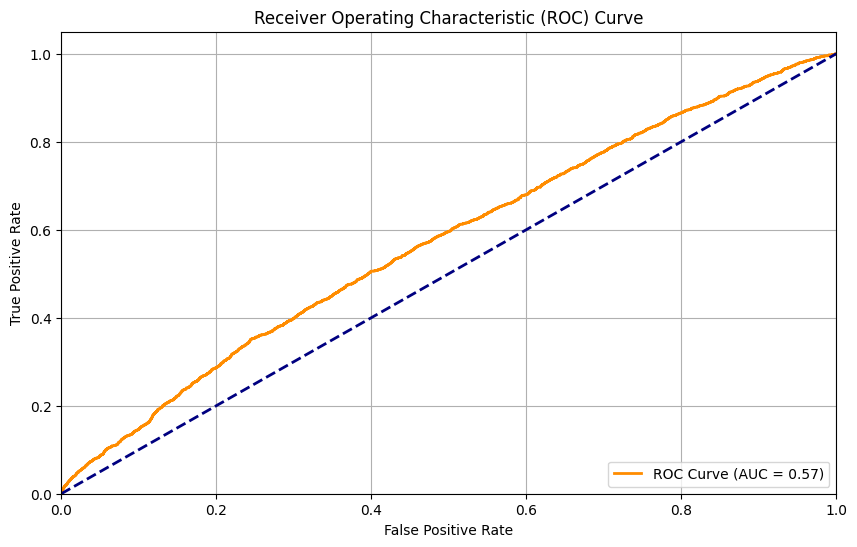

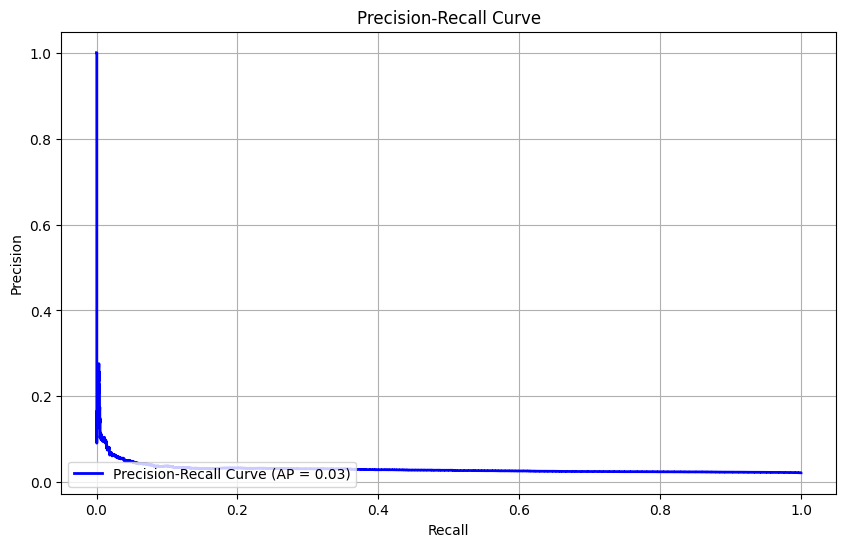

Average Precision Score: 0.0313


In [57]:
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

# Step 2: Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 3: Compute Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_final_prob)
avg_precision = average_precision_score(y_test, y_final_prob)

# Step 4: Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Step 5: Print Average Precision Score
print(f"Average Precision Score: {avg_precision:.4f}")

# HalvingRandomSearchCV Nested Repeated Cross Validation

In [58]:
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=84)

# Use HalvingRandomSearchCV for efficient hyperparameter search
random_search = HalvingRandomSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=inner_cv,
    n_jobs=-1,
    factor=3,
    random_state=42,
)

# Feature Selection using SelectFromModel with XGBoost
feature_selector = SelectFromModel(estimator=xgb_model, threshold='mean', prefit=False)

# Function to run a single iteration of the nested cross-validation
def nested_cv_iteration(train_index, test_index):
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Apply feature selection
    feature_selector.fit(X_outer_train, y_outer_train)
    X_outer_train = feature_selector.transform(X_outer_train)
    X_outer_test = feature_selector.transform(X_outer_test)

    # Perform hyperparameter tuning using HalvingRandomSearchCV
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define Voting Classifier with the tuned model
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model),
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[0.4, 0.4, 0.2],
    )
    voting_model.fit(X_outer_train, y_outer_train)

    # Make predictions and evaluate metrics
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]

    # Return performance metrics
    return {
        'accuracy': accuracy_score(y_outer_test, y_pred),
        'precision': precision_score(y_outer_test, y_pred),
        'recall': recall_score(y_outer_test, y_pred),
        'f1': f1_score(y_outer_test, y_pred),
        'roc_auc': roc_auc_score(y_outer_test, y_prob),
        'mcc': matthews_corrcoef(y_outer_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_outer_test, y_pred),
    }

# Run the nested cross-validation with parallel processing
results = Parallel(n_jobs=-1)(
    delayed(nested_cv_iteration)(train_idx, test_idx) for train_idx, test_idx in outer_cv.split(X_train, y_train)
)

# Collect results and display summary statistics
metrics_df = pd.DataFrame(results)
print(metrics_df.describe())

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=5669. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=5669. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=5669. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=5669. Running 36 iterations. For exhaustive s

# --------------------------------------------------------------------------------------

# Calibrated Classifier Model

Evaluating Calibration Method: sigmoid
Method: sigmoid
Accuracy: 0.9661
Precision: 0.0417
Recall: 0.0254
F1 Score: 0.0316
ROC-AUC: 0.5713
Evaluating Calibration Method: isotonic
Method: isotonic
Accuracy: 0.9737
Precision: 0.0547
Recall: 0.0130
F1 Score: 0.0210
ROC-AUC: 0.5268

Calibration Results Summary:
Method: sigmoid | Accuracy: 0.9661, Precision: 0.0417, Recall: 0.0254, F1 Score: 0.0316, ROC-AUC: 0.5713
Method: isotonic | Accuracy: 0.9737, Precision: 0.0547, Recall: 0.0130, F1 Score: 0.0210, ROC-AUC: 0.5268


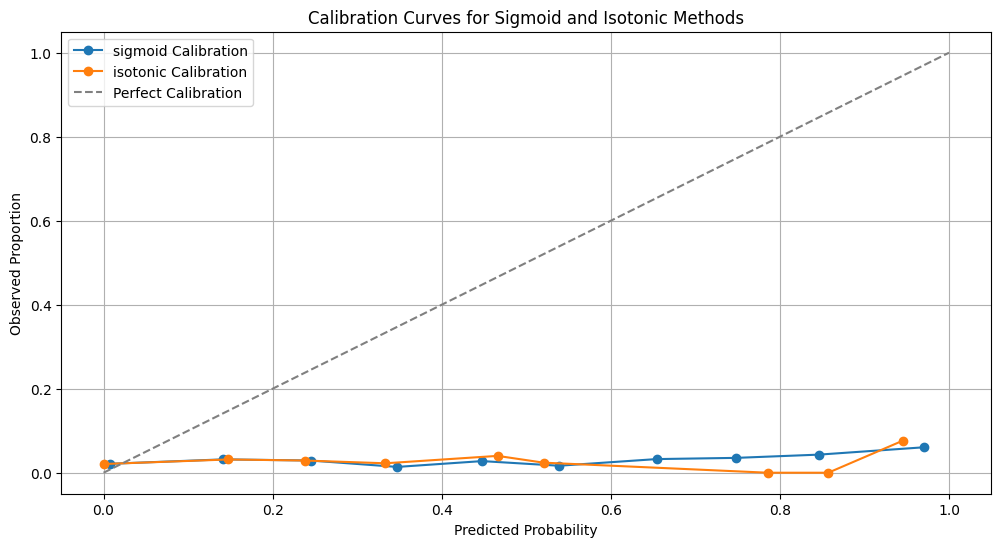

In [59]:
# Fit individual base models before using them in VotingClassifier
xgb_model.fit(X_outer_train, y_outer_train)
rf_model.fit(X_outer_train, y_outer_train)
lr_model.fit(X_outer_train, y_outer_train)

# Define a VotingClassifier with fitted base models
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft',
    weights=[0.4, 0.4, 0.2]
)

# Fit the VotingClassifier on the training set
voting_model.fit(X_outer_train, y_outer_train)

# Import necessary libraries for calibration and metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize list to store performance metrics for calibrated models
calibrated_accuracy = []
calibrated_precision = []
calibrated_recall = []
calibrated_f1 = []
calibrated_roc_auc = []

# Iterate through different calibration methods
calibration_methods = ['sigmoid', 'isotonic']
calibrated_probs = {}  # Dictionary to store calibrated probabilities for plotting

for method in calibration_methods:
    print(f"Evaluating Calibration Method: {method}")

    # Apply calibration using CalibratedClassifierCV
    calibrated_model = CalibratedClassifierCV(estimator=voting_model, method=method, cv='prefit')

    # Fit the calibrated model on the entire outer training set
    calibrated_model.fit(X_outer_train, y_outer_train)

    # Make predictions on the outer test set
    y_calibrated_pred = calibrated_model.predict(X_outer_test)
    y_calibrated_prob = calibrated_model.predict_proba(X_outer_test)[:, 1]
    calibrated_probs[method] = y_calibrated_prob  # Store probabilities for visualization

    # Calculate metrics
    accuracy = accuracy_score(y_outer_test, y_calibrated_pred)
    precision = precision_score(y_outer_test, y_calibrated_pred)
    recall = recall_score(y_outer_test, y_calibrated_pred)
    f1 = f1_score(y_outer_test, y_calibrated_pred)
    roc_auc = roc_auc_score(y_outer_test, y_calibrated_prob)

    # Store metrics
    calibrated_accuracy.append(accuracy)
    calibrated_precision.append(precision)
    calibrated_recall.append(recall)
    calibrated_f1.append(f1)
    calibrated_roc_auc.append(roc_auc)

    # Print results for the current calibration method
    print(f"Method: {method}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

# Summary of calibration results
print("\nCalibration Results Summary:")
for i, method in enumerate(calibration_methods):
    print(f"Method: {method} | Accuracy: {calibrated_accuracy[i]:.4f}, Precision: {calibrated_precision[i]:.4f}, "
          f"Recall: {calibrated_recall[i]:.4f}, F1 Score: {calibrated_f1[i]:.4f}, ROC-AUC: {calibrated_roc_auc[i]:.4f}")

# Plot Calibration Curves
plt.figure(figsize=(12, 6))
for method in calibration_methods:
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_outer_test, calibrated_probs[method], n_bins=10)

    # Plot the calibration curve
    plt.plot(prob_pred, prob_true, marker='o', label=f"{method} Calibration")

# Plot the reference line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Proportion")
plt.title("Calibration Curves for Sigmoid and Isotonic Methods")
plt.legend(loc='best')
plt.grid()
plt.show()


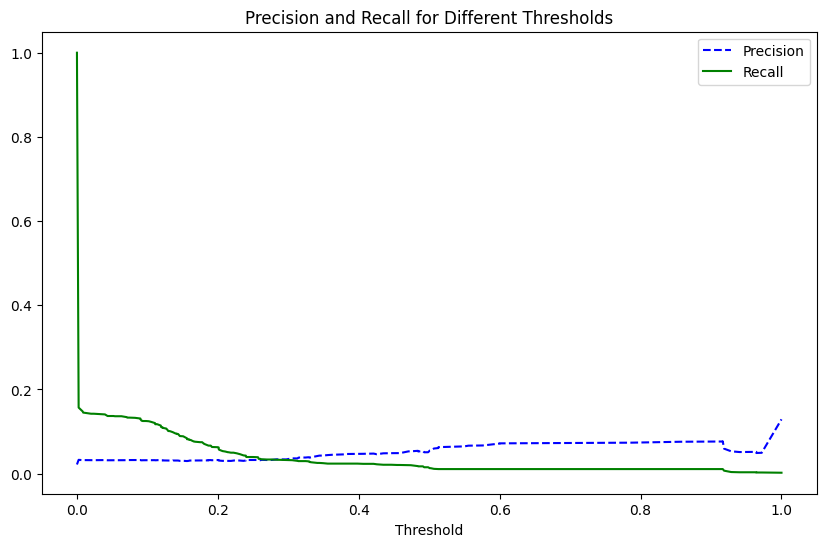

Optimal Threshold: 0.0000
Tuned Model Accuracy: 0.0217
Tuned Model Precision: 0.0217
Tuned Model Recall: 1.0000
Tuned Model F1 Score: 0.0425


In [60]:
# Get calibrated probabilities for the test set
y_calibrated_prob = calibrated_model.predict_proba(X_outer_test)[:, 1]

# Calculate precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_outer_test, y_calibrated_prob)

# Plot precision-recall curve to decide on the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Precision and Recall for Different Thresholds')
plt.show()

# Choose an optimal threshold (e.g., based on business needs)
optimal_threshold = thresholds[np.argmax(precisions * recalls)]  # Maximize the harmonic mean
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Apply the threshold to make predictions
y_tuned_pred = (y_calibrated_prob >= optimal_threshold).astype(int)

# Calculate metrics using the tuned threshold
tuned_accuracy = accuracy_score(y_outer_test, y_tuned_pred)
tuned_precision = precision_score(y_outer_test, y_tuned_pred)
tuned_recall = recall_score(y_outer_test, y_tuned_pred)
tuned_f1 = f1_score(y_outer_test, y_tuned_pred)

print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Tuned Model Precision: {tuned_precision:.4f}")
print(f"Tuned Model Recall: {tuned_recall:.4f}")
print(f"Tuned Model F1 Score: {tuned_f1:.4f}")
